In [1]:
from utils.FaceSketchDataset import FaceSketchDataset
from torch.utils.data import DataLoader
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
from models.unet import UNet
from models.diffusion import Diffusion
import torch

In [2]:
load_dotenv()
DATA_PATH = os.getenv("ROOT_DATA_PATH")

In [3]:
dataset = FaceSketchDataset(root_dir=DATA_PATH, photo_folder='photos', sketch_folder='sketches')
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [4]:
for sketch, photo in dataloader:
    print("Sketch:", sketch.shape, "| Photo:", photo.shape)
    break

Sketch: torch.Size([16, 1, 256, 256]) | Photo: torch.Size([16, 3, 256, 256])


In [5]:
for sketch_batch, photo_batch in dataloader:
    print("Sketch batch:", sketch_batch.shape)  # Expected: (B, 1, 256, 256)
    print("Photo batch:", photo_batch.shape)      # Expected: (B, 3, 256, 256)
    break

Sketch batch: torch.Size([16, 1, 256, 256])
Photo batch: torch.Size([16, 3, 256, 256])


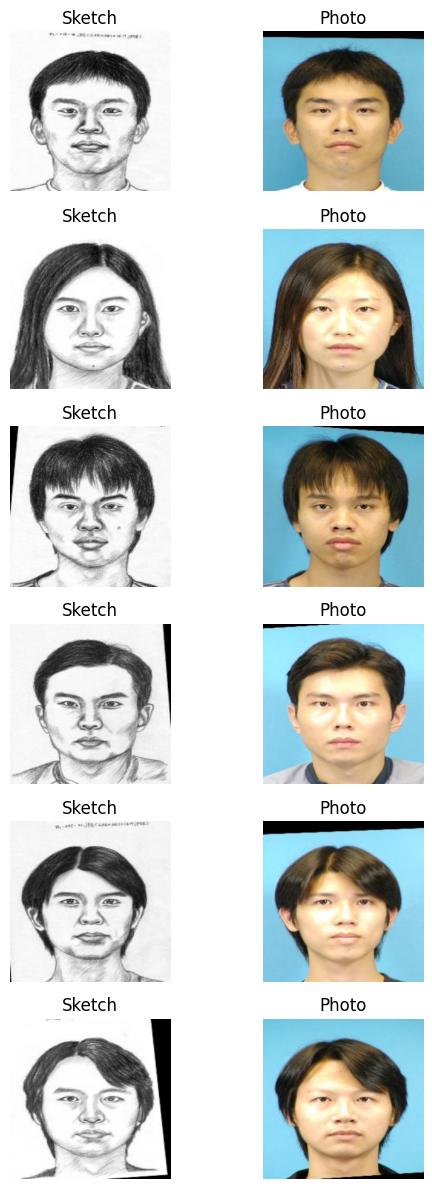

In [6]:
from utils.visualization import show_sketch_photo_batch
show_sketch_photo_batch(sketch_batch, photo_batch)

In [7]:
print("Sketch min/max:", sketch_batch.min().item(), sketch_batch.max().item())
print("Photo min/max:", photo_batch.min().item(), photo_batch.max().item())

Sketch min/max: 0.0 1.0
Photo min/max: 0.0 1.0


Model use

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# Instantiate the model: input channels = 4 (sketch [1] + noisy photo [3]), output channels = 3 (predicted noise for photo)
model = UNet(n_channels=4, n_classes=3).to(device)

In [10]:
# Instantiate the diffusion process
diffusion = Diffusion(timesteps=1000, device=device)

In [11]:
# Grab one batch from the dataloader 
for sketch_batch, photo_batch in dataloader:
    # Move data to device
    sketch_batch = sketch_batch.to(device)
    photo_batch = photo_batch.to(device)
    break  # only need one batch

In [12]:
# Sample random timesteps for each image in the batch
batch_size = sketch_batch.shape[0]
t = diffusion.sample_timesteps(batch_size)

In [13]:
# Add noise to the photo_batch based on the diffusion process
noisy_photo, noise = diffusion.add_noise(photo_batch, t)

In [14]:
# Create conditional input by concatenating the sketch (condition) with the noisy photo along the channel dimension
cond_input = torch.cat([sketch_batch, noisy_photo], dim=1)  # shape: (B, 4, H, W)

In [15]:
# Run a forward pass through the model to predict the noise component
predicted_noise = model(cond_input, t)
print("Predicted noise shape:", predicted_noise.shape)  # Expected: (B, 3, H, W)

Predicted noise shape: torch.Size([16, 3, 256, 256])


In [16]:
# compute a simple MSE loss between the predicted noise and the actual noise
loss = torch.nn.functional.mse_loss(predicted_noise, noise)
print("Sample loss:", loss.item())

Sample loss: 1.1156198978424072


In [17]:
model.eval()

# Start from pure noise for a single sample
with torch.no_grad():
    sample_img = torch.randn((1, 3, 256, 256), device=device)
    
    # List to hold (timestep, image) tuples for visualization.
    intermediate_results = []
    record_interval = 100  # record image every 100 timesteps
    
    # Run the reverse diffusion process
    for t in reversed(range(diffusion.timesteps)):
        t_tensor = torch.tensor([t], device=device)
        # Prepare the conditional input (concatenate sketch with current sample)
        cond_input = torch.cat([sketch, sample_img], dim=1)  # shape: (1, 4, 256, 256)
        predicted_noise = model(cond_input, t_tensor)
        
        beta_t = diffusion.betas[t]
        alpha_t = diffusion.alphas[t]
        alpha_hat_t = diffusion.alpha_hat[t]
        noise = torch.randn_like(sample_img) if t > 0 else 0
        
        # Simplified DDPM reverse diffusion update:
        sample_img = (1 / torch.sqrt(alpha_t)) * (sample_img - (beta_t / torch.sqrt(1 - alpha_hat_t)) * predicted_noise) \
                     + torch.sqrt(beta_t) * noise
        
        # Record the sample image every record_interval steps (or at t==0)
        if t % record_interval == 0 or t == 0:
            intermediate_results.append((t, sample_img.clone().cpu()))
    
    # visualize the intermediate results
    num_results = len(intermediate_results)
    fig, axes = plt.subplots(1, num_results, figsize=(3*num_results, 3))
    
    # for only one image, wrap axes in a list for consistency
    if num_results == 1:
        axes = [axes]
    
    for ax, (t_val, img_tensor) in zip(axes, intermediate_results):
        # Convert tensor image to numpy format for matplotlib: shape (H, W, C)
        img_np = img_tensor.squeeze(0).permute(1, 2, 0).clamp(0, 1).numpy()
        ax.imshow(img_np)
        ax.set_title(f"T = {t_val}")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 16 but got size 1 for tensor number 1 in the list.